In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [ ]:
import numpy as onp
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random

# Generate key which is used to generate random numbers
key = random.PRNGKey(1)

In [19]:
def ReLU(x):
  """Rectified Linear Unit activation function"""
  return np.maximum(0, x)

In [ ]:
def relu_layer(params, x):
  """simple relu layer for sigle sample"""
  return ReLU(np.dot(params[0], x) + params[1])

In [12]:
# Import some additional JAX and dataloader helpers
from jax.scipy.special import logsumexp
from jax.example_libraries import optimizers

import torch
from torchvision import datasets, transforms

import time

In [16]:
from jax._src.random import shuffle
# Set the PyTorch Data Loader for the training & test set
batch_size = 100

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose(
                       [transforms.ToTensor(),
                        transforms.Normalize((0.1307,),(0.3081,))
                        ]
                   )),
                   batch_size=batch_size,shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True,
                   transform=transforms.Compose(
                       [transforms.ToTensor(),
                        transforms.Normalize((0.1307,),(0.3081,))
                        ]
                   )),
                   batch_size=batch_size,shuffle=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



A function that initializes the neural networks weights and returns a list of layer-specific parameters.

In [5]:
def initialize_mlp(sizes, key):
  """Initialize the weights of all layers of a linear layer neural network"""
  keys = random.split(key,len(sizes))
  # Initialize a single layer with Gaussian weights - helper function
  def initialize_layer(m, n, key, scale=1e-2):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

  return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

In [6]:
layer_sizes = [784, 512, 512, 10]
# Return alist of tupples of layer weights
params = initialize_mlp(layer_sizes, key)

A function that performs a forward pass through the network (e.g. by loop over the layers)

In [7]:
def forward_pass(params, in_array):
  """ Compute the forward pass for each example individually"""
  activations = in_array

  # Loop over the ReLU hidden layers
  for w, b in params[:-1]:
    activations = relu_layer([w, b], activations)
  
  # Perform final trafo to logits
  final_w, final_b = params[-1]
  logits = np.dot(final_w, activations) + final_b
  return logits - logsumexp(logits)

In [8]:
# Make a batched version of the "predict" function
batch_forward = vmap(forward_pass, (None, 0), 0)

*   A function that computes the cross-entropy loss of 
the predictions.
*   A function that evaluates the accuracy of the network (simply for logging).

In [9]:
def one_hot(x, k, dtype=np.float32):
  """ Create a one-hot encoding of x of size k"""
  return np.array(x[:,None] == np.arange(k), dtype)

def loss(params, in_array, targets):
  """ Compute the multi-class cross-entry loss"""
  preds = batch_forward(params, in_array)
  return -np.sum(preds * targets)

def accuracy(params, data_loader):
  """ Compute the accuracy for a provided dataloader"""
  acc_total = 0
  for batch_idx, (data, target) in enumerate(data_loader):
    images = np.array(data).reshape(data.size(0), 28*28)
    targets = one_hot(np.array(target), num_classes)

    target_class = np.argmax(targets, axis=1)
    predicted_class = np.argmax(batch_forward(params, images), axis=1)
    acc_total += np.sum(predicted_class == target_class)
  return acc_total/len(data_loader.dataset) 

A function that updates the parameters using some form gradient descent.

In [13]:
@jit
def update(params, x, y, opt_state):
  """ Implements a learning loop over epochs"""
  value, grads = value_and_grad(loss)(params, x, y)
  opt_state = opt_update(0, grads, opt_state)
  return get_params(opt_state), opt_state, value

# Define an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

num_classes = 10
num_epochs = 10


Having setup everythong! It's time to run the learning loop for the 2-layer MLP.

In [14]:
def run_mnist_training_loop(num_epochs, opt_state, net_type="MLP"):
  """ Implements a learning loop over epochs. """
  # Initialize placeholder for loggin
  log_acc_train, log_acc_test, train_loss = [],[],[]

  # Get the initial set of parameters
  params = get_params(opt_state)

  # Get initial accuracy after random init
  train_acc = accuracy(params, train_loader)
  test_acc = accuracy(params, test_loader)
  log_acc_train.append(train_acc)
  log_acc_test.append(test_acc)

  # Loop over the training epochs
  for epoch in range(num_epochs):
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):
      if net_type == "MLP":
        x = np.array(data).reshape(data.size(0), 28*28)
      elif net_type =="CNN":
        x = np.array(data)
      y = one_hot(np.array(target), num_classes)
      params, opt_state, loss = update(params, x, y, opt_state)
      train_loss.append(loss)

    epoch_time =time.time() - start_time
    train_acc = accuracy(params, train_loader)
    test_acc = accuracy(params, test_loader)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)
    print("Epoch{} |T:{:0.2f} |Train A:{:0.3f}| Test A:{:0.3f}".format(epoch+1,epoch_time, train_acc, test_acc))

  return train_loss, log_acc_train, log_acc_test

In [21]:
train_loss, train_log, test_log = run_mnist_training_loop(
    num_epochs, opt_state ,net_type="MLP"
    )

Epoch1 |T:24.73 |Train A:0.975| Test A:0.969
Epoch2 |T:23.94 |Train A:0.985| Test A:0.976
Epoch3 |T:24.07 |Train A:0.990| Test A:0.980
Epoch4 |T:24.12 |Train A:0.991| Test A:0.979
Epoch5 |T:24.03 |Train A:0.996| Test A:0.980
Epoch6 |T:24.01 |Train A:0.996| Test A:0.981
Epoch7 |T:24.14 |Train A:0.997| Test A:0.983
Epoch8 |T:24.05 |Train A:0.997| Test A:0.982
Epoch9 |T:24.01 |Train A:0.998| Test A:0.982
Epoch10 |T:23.94 |Train A:0.998| Test A:0.983


In [25]:
import matplotlib.pyplot as plt

In [37]:
def plot_performance(train_loss, train_log, test_log, title):
  plt.subplot(121)
  plt.plot(x,y,label="Training Loss", color="g")
  plt.xlabel("Batch Updates")
  plt.ylabel("Batch Loss")
  plt.title("Training Loss")
  plt.subplot(122)
  t = np.arange(len(train_log))
  y1 = train_log
  y2 = test_log
  plt.plot(t,y1,label="Training", color="b")
  plt.plot(t,y2,label="Test", color="r")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Predictive Accuracy")
  plt.legend()
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=0.5)
  plt.suptitle(title)
  plt.show()

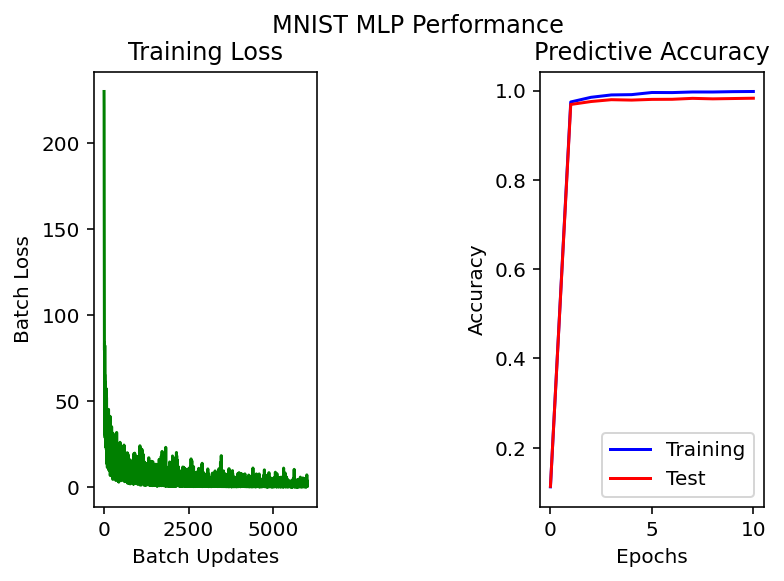

In [38]:
plot_performance(train_loss, train_log, test_log, "MNIST MLP Performance")